# AIRLINE PASSENGER SATISFACTION PREDICTION

## Data reading and libraries importing

Let's import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# let's read the dataset previosly downloaded

df = pd.read_csv('datasets/train.csv', index_col=0)
pd.set_option('display.max_columns', None)
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


## EDA

**IMPORTANT:** For all the data preprocessing procedure we are going to create functions, in order to can use them as a pipeline for the dataset test.csv who will have the same data structure of the train.csv file

Let's see datatypes

In [3]:
df.dtypes

id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival De

In [4]:
# let's set object type as category type
def converting_to_category(df):
    for column in df.columns:
        if df[column].dtype == np.dtype('O'):
            df[column] = df[column].astype('category')

converting_to_category(df)

Checking duplicates

In [5]:
# let's see duplicate passengers
print(f'There are {df.shape[0]} rows and {len(df.id.drop_duplicates())} distinct passengers')

There are 103904 rows and 103904 distinct passengers


Checking missing values

In [6]:
def checking_missing_values(df):
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            print(f'Feature: {column} has {df[column].isnull().sum()} missing values, {df[column].dtype}')

checking_missing_values(df)

Feature: Arrival Delay in Minutes has 310 missing values, float64


Missing values imputation

In [7]:
# let's replace missing values by mean

def mean_imputation(df, to_imput):
    mean =  df[to_imput].loc[np.where(df[to_imput]>0)].mean()
    df[to_imput].replace(np.nan, mean, inplace = True)

mean_imputation(df, 'Arrival Delay in Minutes')

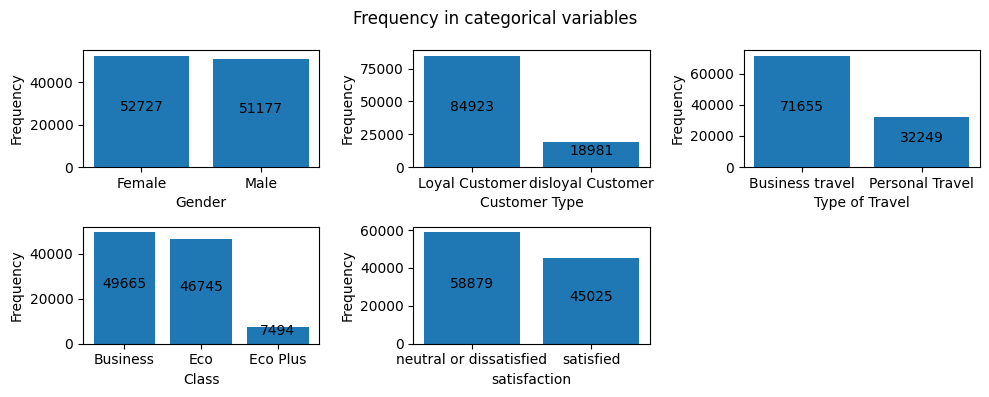

In [8]:
categorical_features = df.select_dtypes('category').columns
plt.figure(figsize=(10,4))
plot = 1

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')

for feature in categorical_features:
    plt.subplot(2,3,plot)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    x = df[feature].value_counts().index.to_list()
    y = df[feature].value_counts().values
    plt.bar(x, y)
    addlabels(x,y)
    plot += 1


plt.suptitle('Frequency in categorical variables')
plt.tight_layout() 
plt.show()

From the previous visualization we can assume that both genders have an aproximate participation in the survey, there are more opinions from passenger who flew in business travel, and business and eco class are the most buyed ticket classes.
In adition, our target variable 'satisfaction' is about balanced.

In [9]:
satisfaction = df.groupby(['Gender', 'satisfaction']).agg({'id':'count'}).reset_index().rename(columns = {'id':'cases'})
satisfaction

,Gender,satisfaction,cases
0,Female,neutral or dissatisfied,30193
1,Female,satisfied,22534
2,Male,neutral or dissatisfied,28686
3,Male,satisfied,22491


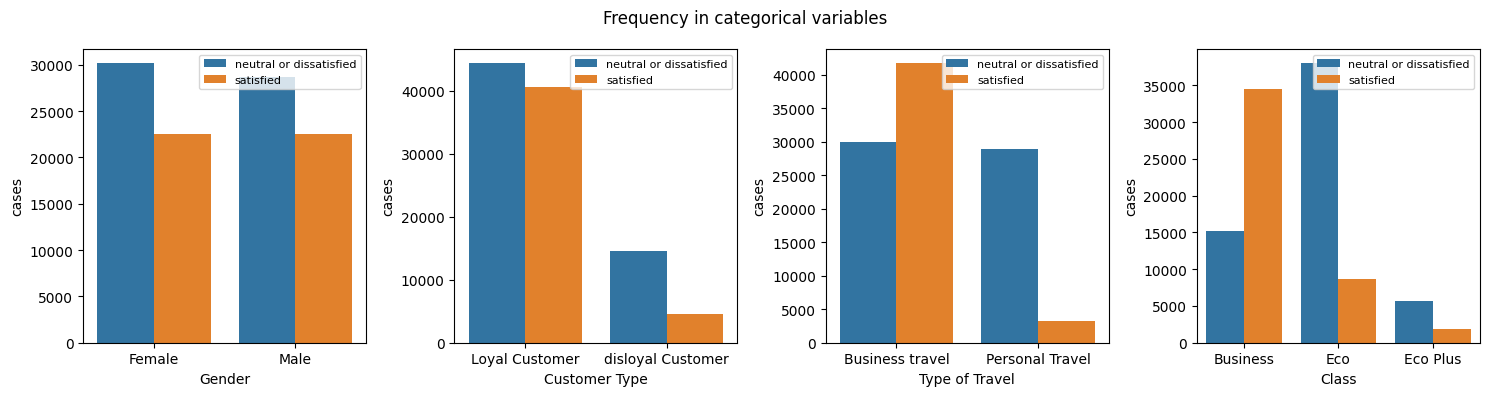

In [10]:

plt.figure(figsize=(15,4))
plot = 1
a = list(categorical_features)
a.pop(4)
a

for feature in a:
    plt.subplot(1,4,plot)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    aux_df = df.groupby([feature, 'satisfaction']).agg({'id':'count'}).reset_index().rename(columns = {'id':'cases'}) # using the logic of upper cell
    sns.barplot(data = aux_df, x = feature, y = 'cases', hue = 'satisfaction')
    plt.legend(loc=1, prop={'size': 8})
    plot += 1


plt.suptitle('Frequency in categorical variables')
plt.tight_layout() 
plt.show()

We can see how the satisfaction varies within all the categorical variables and them categories. Also, we can check that there aren't inconsistences in the categories of these variables, so we don't need to do a cleaning process on them.

In [11]:
# the scores of the variables that compose the surveys should be between 0 and 5, let's test it
numerical_variables = df.drop(columns = categorical_features).columns
df[numerical_variables].describe()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.236646
std,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.655437
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


Outliers in continuous variables

<AxesSubplot: title={'center': 'Boxplot for outlier analysis'}>

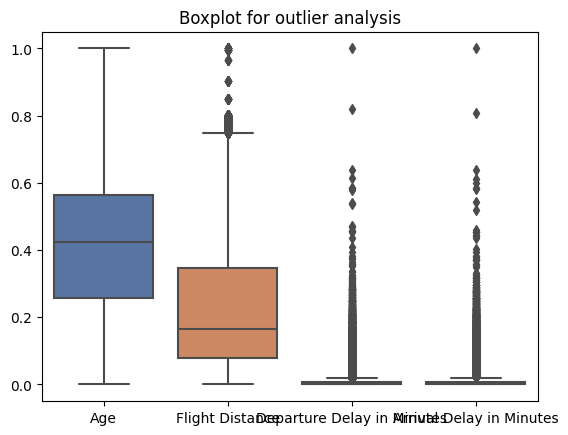

In [12]:
# Let's do a scaling process in continuous variables in order to see outliers (just visualization purposes, we will scale later)

from sklearn.preprocessing import MinMaxScaler
plt.title('Boxplot for outlier analysis')
scaler = MinMaxScaler()
sns.set(rc={'figure.figsize':(15,3)})
sns.boxplot(data = pd.DataFrame(scaler.fit_transform(df[['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']]) \
    , columns = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']))

In [13]:
# let's remove outliers from "Flight Distance", "Departure Delay in Minutes" and "Arrival Delay in Minutes" features
# this function won't be applied in test.csv

def remove_outliers(df, column):
    q1 = np.quantile(df[column], 0.25)
    q3 = np.quantile(df[column], 0.75)
    iqr = q3-q1
    cond1 = q1 - (1.5 * iqr)
    cond2 = q3 + (1.5 * iqr)
    median = df[column].median()
    df[column] = np.where((df[column] < cond1) | (df[column] > cond2), median, df[column] )

In [14]:
for feature in ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']:
    remove_outliers(df, feature)

In [15]:
# let's create a dict that contains the discretization of the satisfaction values
targets = list(df['satisfaction'].drop_duplicates().values)
target = {}
for i in range(len(targets)):
    target[i]  = targets[i]

target_translator = dict(zip(target.values(), target.keys())) # we do this to change from {0: 'neutral or dissatisfied'... to {'neutral or dissatisfied': 0 ...

def convert_target(df, feature_base, translator): # to convert satisfaction values to binary
    df['target'] = df[feature_base].replace(translator).astype('int64')

convert_target(df, 'satisfaction', target_translator )

In [16]:
# let's divide the DataFrame into X and y
def X_y_sets(df):
    X = df.drop(columns = ['id', 'satisfaction', 'target'])
    y = df['target'].values
    return X,y

X,y = X_y_sets(df)

## Feature Selection

Let's see a correlation matrix in order to find high correlated features that could be removed

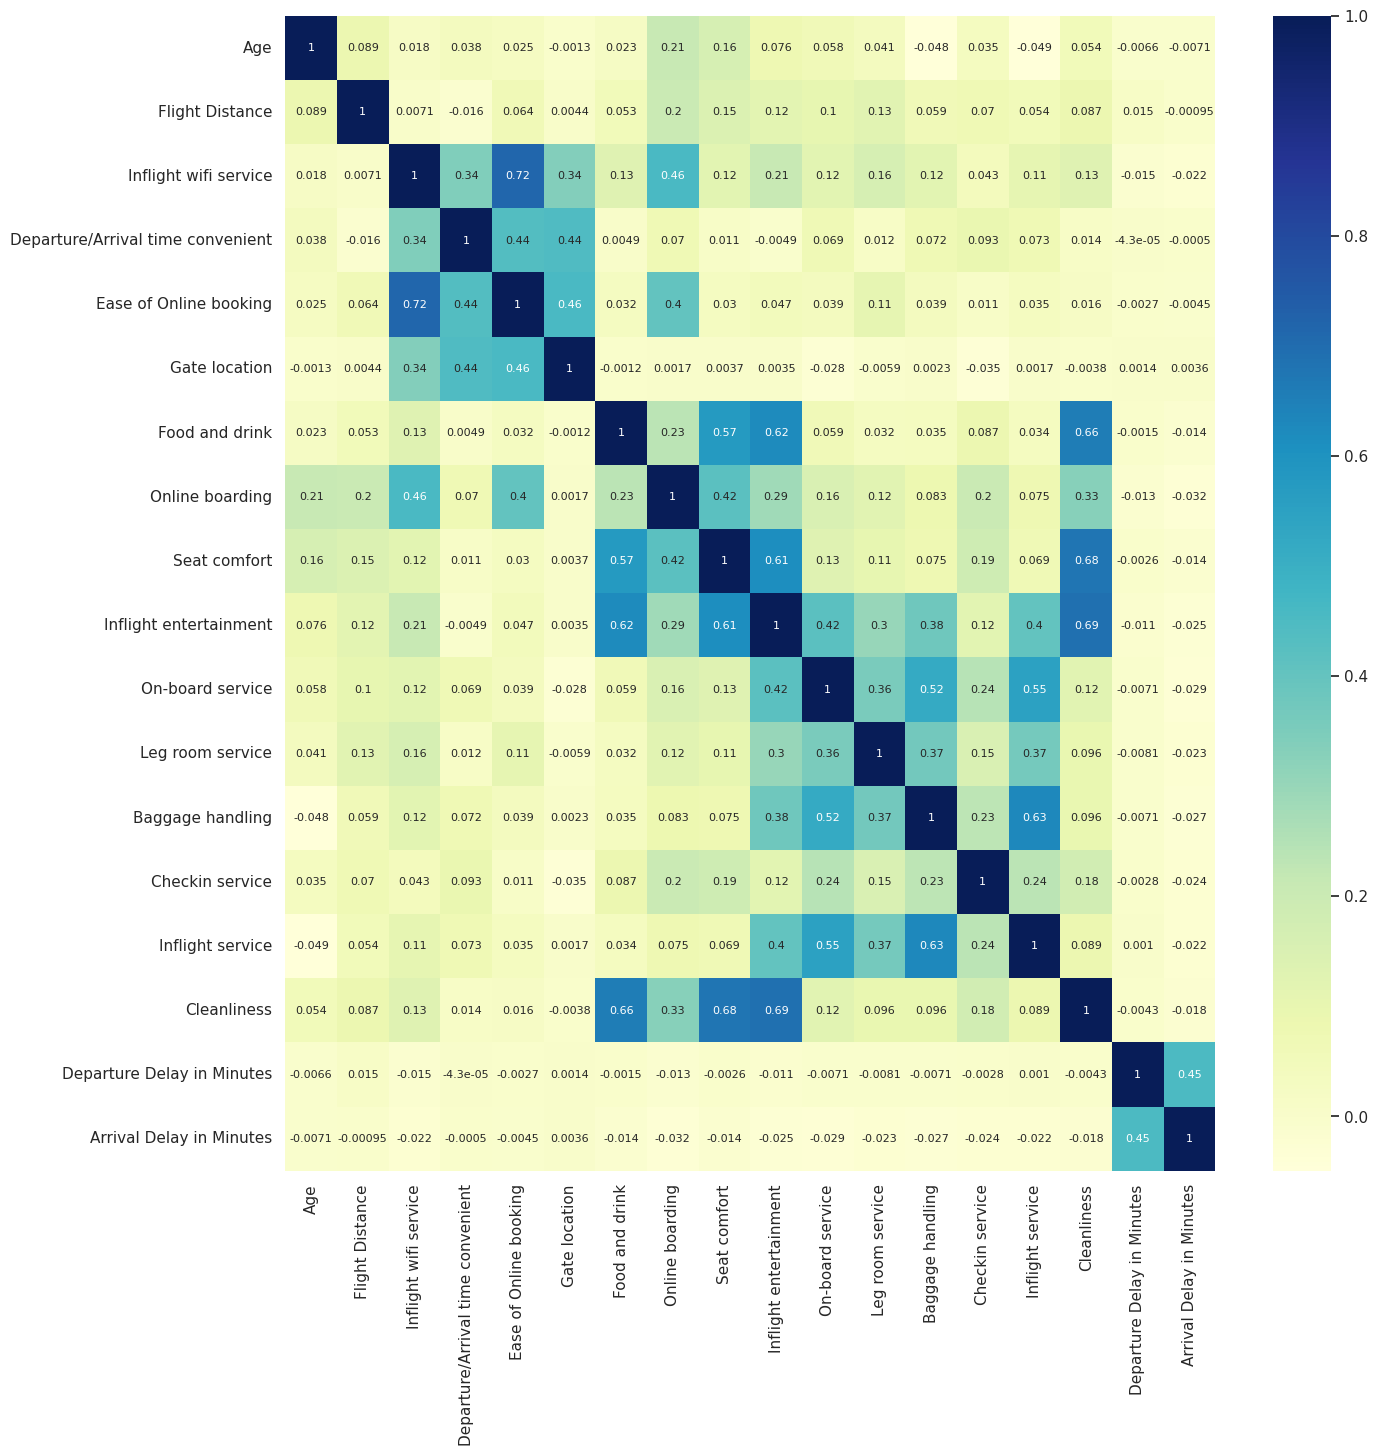

In [17]:
corr = X.corr()
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(data = corr, annot = True, cmap = 'YlGnBu', annot_kws={"size": 8})
plt.show()

There are some correlation values higher than 0.7 that is the standard for high correlated values. So we can drop some of this features

In [18]:
# thinking about the pipeline to implement, let's store in a list all the columns that will be dropped
to_drop = []

X.drop(columns = ['Ease of Online booking'], inplace = True)
to_drop.append('Ease of Online booking')

#### Categorical features selection with chi2

In [19]:
from sklearn.preprocessing import OrdinalEncoder # let's encode categorical values to apply chi2 test
encoder = OrdinalEncoder()
a = X.select_dtypes('category') # to select only categorical features 
encoded_features = pd.DataFrame(encoder.fit_transform(a).astype('int64'), columns = a.columns)
encoded_features.head()


,Gender,Customer Type,Type of Travel,Class
0,1,0,1,2
1,1,1,0,0
2,0,0,0,0
3,0,0,0,0
4,1,0,0,0


In [20]:
from sklearn.feature_selection import chi2

chi_scores = chi2(encoded_features, y)
p_values = pd.Series(chi_scores[1], index = encoded_features.columns)
p_values.sort_values(ascending = False, inplace = True)
p_values

Gender            0.005047
Customer Type     0.000000
Type of Travel    0.000000
Class             0.000000
dtype: float64

We can see that all categorical variables help to explain the target variable 

#### Numerical features selection with ANOVA F measure

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif

numerical_features = X.select_dtypes(['int64', 'float64'])
fs = SelectKBest(score_func = f_classif, k = numerical_features.shape[1])
X_selected = fs.fit_transform(numerical_features, y)
print(X_selected.shape)

(103904, 17)


In [22]:
# print scores for the features
for i in range(len(fs.scores_)):
	print('Feature: {:}, p-value: {:.5f}'.format(numerical_features.columns[i], fs.pvalues_[i]))

Feature: Age, p-value: 0.00000
Feature: Flight Distance, p-value: 0.00000
Feature: Inflight wifi service, p-value: 0.00000
Feature: Departure/Arrival time convenient, p-value: 0.00000
Feature: Gate location, p-value: 0.82599
Feature: Food and drink, p-value: 0.00000
Feature: Online boarding, p-value: 0.00000
Feature: Seat comfort, p-value: 0.00000
Feature: Inflight entertainment, p-value: 0.00000
Feature: On-board service, p-value: 0.00000
Feature: Leg room service, p-value: 0.00000
Feature: Baggage handling, p-value: 0.00000
Feature: Checkin service, p-value: 0.00000
Feature: Inflight service, p-value: 0.00000
Feature: Cleanliness, p-value: 0.00000
Feature: Departure Delay in Minutes, p-value: 0.00000
Feature: Arrival Delay in Minutes, p-value: 0.00000


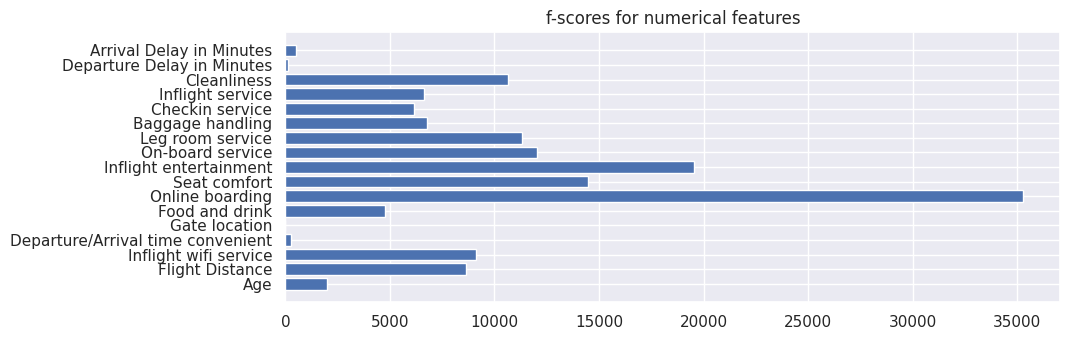

In [23]:
# plotting the f-scores to see if we can drop other features having good p-values but not the most important features

plt.figure(figsize = (10,3.5))
plt.barh([numerical_features.columns[i] for i in range(len(fs.scores_))], fs.scores_)
plt.title('f-scores for numerical features')
plt.show()

Let's drop columns with p-values upper 0.05 and some of the columns that have the lower f-scores

In [24]:
X.drop(columns = ['Gate location', 'Departure Delay in Minutes'], inplace = True)

to_drop.extend(['Gate location', 'Departure Delay in Minutes']) # updating list of features to drop

In [25]:
# let's do the encoding for categorical variables
def dummification(df):
    dummies = pd.get_dummies(df.select_dtypes('category'))
    X = pd.concat([df.select_dtypes(['int64', 'float64']), dummies], axis = 1)
    return X

X = dummification(X)
X.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,13,460.0,3,4,5,3,5,5,4,3,4,4,5,5,18.0,0,1,1,0,0,1,0,0,1
1,25,235.0,3,2,1,3,1,1,1,5,3,1,4,1,6.0,0,1,0,1,1,0,1,0,0
2,26,1142.0,2,2,5,5,5,5,4,3,4,4,4,5,0.0,1,0,1,0,1,0,1,0,0
3,25,562.0,2,5,2,2,2,2,2,5,3,1,4,2,9.0,1,0,1,0,1,0,1,0,0
4,61,214.0,3,3,4,5,5,3,3,4,4,3,3,3,0.0,0,1,1,0,1,0,1,0,0


In [26]:
# Scaling all our variables
def scale_features(df):
    X = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
    return X

X = scale_features(X)

## Splitting training data into train and test

We already know that the file previously downloaded has 2 .csv, train and test. We are going to train and test with train.csv and then test again with test.csv

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 15, test_size=0.2)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (83123, 24), y_train shape: (83123,)
X_test shape: (20781, 24), y_test shape: (20781,)


## Modeling and training

#### Let's use a GridSearch to train some models simultaneously (Hyperparameters tuning)

In [28]:
# importing all models to use 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

Hyperparemeter tuning for RandomForestClassifier

In [29]:
clf_rf = GridSearchCV(RandomForestClassifier(),
                    {'n_estimators': [250, 300, 350], 'max_depth': [5, 7, 9]}, \
                    cv = 5, 
                    return_train_score=False, 
                    n_jobs=-1)

In [30]:
clf_rf.fit(X_train, y_train.ravel())
pd.DataFrame(clf_rf.cv_results_).sort_values(by = 'rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,31.797250,1.909896,0.670014,0.104104,9,350,"{'max_depth': 9, 'n_estimators': 350}",0.941835,0.940271,0.941113,0.938884,0.940748,0.940570,0.000986,1
6,32.126215,1.025886,0.968189,0.046453,9,250,"{'max_depth': 9, 'n_estimators': 250}",0.941955,0.940211,0.940692,0.937981,0.941290,0.940426,0.001355,2
7,33.448721,2.430699,0.813400,0.101102,9,300,"{'max_depth': 9, 'n_estimators': 300}",0.941053,0.939850,0.940692,0.937981,0.940929,0.940101,0.001140,3
3,28.608404,0.930255,0.741911,0.010573,7,250,"{'max_depth': 7, 'n_estimators': 250}",0.933353,0.931429,0.932150,0.928778,0.932628,0.931668,0.001575,4
4,33.610741,1.576379,0.927273,0.055647,7,300,"{'max_depth': 7, 'n_estimators': 300}",0.932211,0.932511,0.932150,0.927514,0.931424,0.931162,0.001859,5


Hyperparemeter tuning for LogisticRegression

In [31]:
clf_lr = GridSearchCV(LogisticRegression(solver = 'saga', max_iter=1000), 
                        {'C': [1, 5, 10], 'penalty': ['l1', 'l2']},
                        cv = 5,
                    return_train_score=False, 
                    n_jobs=-1)

clf_lr.fit(X_train, y_train)
pd.DataFrame(clf_lr.cv_results_).sort_values(by = 'rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,10.602419,0.502888,0.006453,0.000564,1,l2,"{'C': 1, 'penalty': 'l2'}",0.87603,0.872,0.874406,0.872474,0.879572,0.874896,0.002744,1
3,33.007816,1.077195,0.004660,0.000130,5,l2,"{'C': 5, 'penalty': 'l2'}",0.87603,0.872,0.874346,0.872293,0.879632,0.874860,0.002799,2
4,34.839119,1.315905,0.004330,0.000681,10,l1,"{'C': 10, 'penalty': 'l1'}",0.87609,0.872,0.874286,0.872233,0.879632,0.874848,0.002818,3
5,37.601506,4.148036,0.002781,0.000342,10,l2,"{'C': 10, 'penalty': 'l2'}",0.87603,0.872,0.874286,0.872233,0.879632,0.874836,0.002812,4
2,17.307590,0.605971,0.005505,0.001146,5,l1,"{'C': 5, 'penalty': 'l1'}",0.87609,0.872,0.874286,0.872173,0.879632,0.874836,0.002829,5


Hyperparemeter tuning for KNN

In [32]:
clf_knn = GridSearchCV(KNeighborsClassifier(n_neighbors = round(np.sqrt(X.shape[0])), n_jobs = -1),
                        {'weights' :['uniform', 'distance'], 'p': [1, 2]},
                        cv = 5,
                        return_train_score = False,
                        n_jobs = -1
)

clf_knn.fit(X_train, y_train)
pd.DataFrame(clf_knn.cv_results_).sort_values(by = 'rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.088767,0.006069,49.730410,1.662588,1,distance,"{'p': 1, 'weights': 'distance'}",0.902195,0.901955,0.900451,0.900084,0.903092,0.901556,0.001124,1
0,0.037790,0.012395,49.679361,1.452824,1,uniform,"{'p': 1, 'weights': 'uniform'}",0.900391,0.901113,0.898887,0.898460,0.901107,0.899992,0.001116,2
3,0.027940,0.005199,12.598236,2.095768,2,distance,"{'p': 2, 'weights': 'distance'}",0.900271,0.897925,0.895880,0.895573,0.899302,0.897790,0.001845,3
2,0.051734,0.035083,15.206713,0.696136,2,uniform,"{'p': 2, 'weights': 'uniform'}",0.897684,0.895459,0.893534,0.893347,0.897197,0.895444,0.001797,4


####

Let's select the best model

In [33]:
rf_model = clf_rf.best_estimator_
lr_model = clf_lr.best_estimator_
knn_model = clf_knn.best_estimator_

import joblib
# training the models to then save them
models = [rf_model, lr_model, knn_model]
model_names = [] # to save the name of the models with .joblib extension
for model in models:
    model.fit(X_train, y_train)
    joblib.dump(model, str(model.__class__()).lower().replace('()','.joblib'))
    model_names.append(str(model.__class__()).lower().replace('()','.joblib'))


## Predicting and testing with new data

In [34]:
#  reading the dataset for testing

test_df = pd.read_csv('datasets/test.csv', index_col = 0)

Now let's apply the pipeline based on the data preprocessing we've made previosly

In [35]:
converting_to_category(test_df)
checking_missing_values(test_df)

Feature: Arrival Delay in Minutes has 83 missing values, float64


In [36]:
# we have the same feature we null values as in train.csv. Let's apply the rest of the defined functions
from sklearn.model_selection import cross_val_score

mean_imputation(test_df, 'Arrival Delay in Minutes') 
convert_target(test_df, 'satisfaction', target_translator) # creates a new variable called target with binary values
X_test, y_test = X_y_sets(test_df) # divides the dataset into X and y
X_test.drop(columns = to_drop, inplace = True) # drops all the columns stored in the defined list
X_test = dummification(X_test) # applies dummification to categorical variables with pd.get_dummies
X_test = scale_features(X_test) #scale features with the fit of training datases

# let's import the models and test them

tested_models = []
for model in model_names:
    the_model = joblib.load(model)
    print(f'The {model} has {round(cross_val_score(the_model, X_test, y_test, cv = 5).mean(),3)} score in a cross validation with cv = 5 on testing data')
    tested_models.append(the_model)

The randomforestclassifier.joblib has 0.941 score in a cross validation with cv = 5 on testing data
The logisticregression.joblib has 0.87 score in a cross validation with cv = 5 on testing data
The kneighborsclassifier.joblib has 0.894 score in a cross validation with cv = 5 on testing data


## Metrics

ROC & AUC

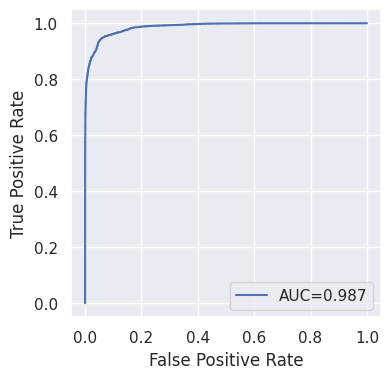

In [37]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

production_model = tested_models[0]

def plot_roc_curve(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = round(roc_auc_score(y_test, y_pred_proba),3)
    #create ROC curve
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

plot_roc_curve(production_model, X_test, y_test)


Precision, recall and others

In [38]:
print(classification_report(y_test, production_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     14573
           1       0.94      0.93      0.93     11403

    accuracy                           0.94     25976
   macro avg       0.94      0.94      0.94     25976
weighted avg       0.94      0.94      0.94     25976



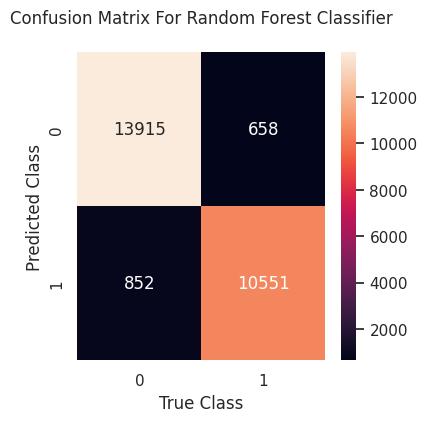

In [39]:
matrix = confusion_matrix(y_test, production_model.predict(X_test))
plt.figure(figsize= (4,4))
sns.heatmap(matrix, annot = True, fmt = '.0f')
plt.title('Confusion Matrix For Random Forest Classifier\n')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()